In [117]:
import rhinoinside
rhinoinside.load()
import System
from Rhino.Geometry import Point3d, Plane, Brep, Vector3d
from Rhino.Geometry import Surface as RhinoSurface
import Rhino.Geometry as rg
from Rhino.Geometry import Polyline
from Rhino.Collections import Point3dList
from Rhino.Geometry import PolylineCurve
from Rhino.Geometry import Transform
from Rhino.FileIO import File3dm

In [118]:
# Paramètres de configuration
GRID_SIZE = 100 # Taille du champ de panneau pour la simulation
ENTRAXE = 2.5 # Espacement entre lignes de panneaux (= inter-rang)
HAUTEUR = 3 # [0 ; 100] ; mètres ; hauter de l'axe de rotation, ou du point du PVP le plus bas.
RAMPANT = 1.135 # Largeur du panneau
NB_RANGS = 20 # Nombre de panneaux par ligne
NB_PVP_RANGS = int(GRID_SIZE / ENTRAXE) # Nombre de lignes
LONGUEUR_PVP = GRID_SIZE / (NB_RANGS) # Longueur des panneaux dans une même ligne

column_spacing = ENTRAXE # Espacement entre lignes de panneaux (= inter-rang)
row_spacing = GRID_SIZE / NB_RANGS # Espacement entre panneaux d'une même ligne (même support)

ANGLE_ORIENTATION = 45  # Rotation globale autour de l'axe Z
ANGLE_VARIABLE = 10  # Angle de rotation individuelle autour de l'axe X

print(LONGUEUR_PVP)
print(row_spacing)
print(NB_RANGS)
print(NB_PVP_RANGS)

5.0
5.0
20
40


In [119]:
def create_surface(x, y, length, width):
    
    points = Point3dList()
    points.Add(x, y, 0)
    points.Add(x + width, y, 0),
    points.Add(x + width, y + length, 0),
    points.Add(x, y + length, 0),
    points.Add(x, y, 0)

    # Créer une polyline
    polyline = PolylineCurve(points)
    
    # Vérifier si la polyline est fermée
    if polyline.IsClosed:
        # Créer une extrusion de la polyline
        direction = Vector3d(0, 0, 0.001)  # Direction d'extrusion (minimale pour simuler une surface)
        surface = RhinoSurface.CreateExtrusion(polyline, direction)  # Extrusion minime
        return surface
    else:
        return None

In [120]:
def create_and_rotate_grid(nb_rangs, nb_pvp_rangs, width, length, column_spacing, row_spacing, angle_orientation, angle_variable):
    grid_surfaces = []

    for i in range(nb_rangs):
        for j in range(nb_pvp_rangs):
            x = (j * column_spacing) - GRID_SIZE / 2
            y = (i * row_spacing) - GRID_SIZE / 2
            surface = create_surface(x, y, length, width)
            if surface:
                # Rotation autour de l'axe X pour chaque Brep individuellement
                center_of_surface = Point3d(x + length / 2, y + width / 2, 0)
                rotation_x = Transform.Rotation(angle_variable * (System.Math.PI / 180), Vector3d.YAxis, center_of_surface)
                surface.Transform(rotation_x)
                grid_surfaces.append(surface.ToBrep())

    # Assembler tous les Brep en un seul
    final_brep = rg.Brep()
    for brep in grid_surfaces:
        final_brep.Append(brep)
 
    # Rotation globale autour de l'axe Z au centre de la grille (origine)
    rotation_z = Transform.Rotation(angle_orientation * (System.Math.PI / 180), Vector3d.ZAxis, rg.Point3d.Origin)
    final_brep.Transform(rotation_z)

    # Translation globale sur l'axe Z, équivalente à la hauteur de l'entraxe
    translation_z = Transform.Translation(0,0,HAUTEUR)
    final_brep.Transform(translation_z)
    
    return final_brep

In [121]:
### VISUALISATION AVEC RHINO
def export_brep_to_file(brep, filename):
    file = File3dm()
    file.Objects.AddBrep(brep)
    file.Write(filename, 7)  # Version 7 pour Rhino 7

In [123]:
final_rotated_brep = create_and_rotate_grid(NB_RANGS, NB_PVP_RANGS, RAMPANT, LONGUEUR_PVP, column_spacing, row_spacing, ANGLE_ORIENTATION, ANGLE_VARIABLE)

### VISUALISATION AVEC RHINO
export_brep_to_file(final_rotated_brep, "output2.3dm")

Géométrie prête !

IMPORT_EPW

In [110]:
from __future__ import division

import collections
import array
import math
try:
    import Rhino.UI as rui
except ImportError as e:
    raise ImportError("Failed to import Rhino.\n{}".format(e))
import ladybug.epw as epw

In [111]:
_epw_file_path = "FRA_AC_Agen-La.Garenne.AP.075240_TMYx.epw"

epw_data = epw.EPW(_epw_file_path)
location = epw_data.location #######
direct_normal_rad = epw_data.direct_normal_radiation #########
diffuse_horizontal_rad = epw_data.diffuse_horizontal_radiation #########

SKY_MATRIX

In [112]:

try:
    from ladybug_geometry.geometry2d.pointvector import Vector2D
except ImportError as e:
    raise ImportError('\nFailed to import ladybug_geometry:\n\t{}'.format(e))

try:
    from ladybug_radiance.skymatrix import SkyMatrix
except ImportError as e:
    raise ImportError('\nFailed to import ladybug:\n\t{}'.format(e))

try:
    from ladybug_rhino.togeometry import to_vector2d
except ImportError as e:
    raise ImportError('\nFailed to import ladybug_rhino:\n\t{}'.format(e))

try:
    from lbt_recipes.version import check_radiance_date
except ImportError as e:
    raise ImportError('\nFailed to import honeybee_radiance:\n\t{}'.format(e))

# check the istalled Radiance date and get the path to the gemdaymtx executable
check_radiance_date()

In [114]:
###SKY MATRIX
# process and set defaults for all of the global inputs
north_ = None
_location = location
_direct_rad = direct_normal_rad
_diffuse_rad = diffuse_horizontal_rad
_folder_ = "C:/Users/maceo.valente/Documents/Automatisation/TEST_MVA/TSAgriPV/cielMatrices"
 
if north_ is not None:  # process the north_
    try:
        north_ = math.degrees(
            to_vector2d(north_).angle_clockwise(Vector2D(0, 1)))
    except AttributeError:  # north angle instead of vector
        north_ = float(north_)

# create the sky matrix object
sky_mtx = SkyMatrix.from_components(
    _location, _direct_rad, _diffuse_rad, 
    #_hoys_, north_, high_density_, ground_r
    )
if _folder_:
    sky_mtx.folder = _folder_

print(sky_mtx.north)

0


Créer une surface de récupération des données :

In [131]:
# # Paramètres pour créer un carré centré sur l'origine
# side_length = 10
# x = -side_length / 2  # Ajuster pour centrer sur l'origine
# y = -side_length / 2  # Ajuster pour centrer sur l'origine
# square_brep = create_surface(x, y, side_length, side_length)

# ##VISUALISATION
# # Ouverture du fichier .3dm existant
# file_path = "output2.3dm"
# file = File3dm.Read(file_path)
# if square_brep:
#     file.Objects.AddBrep(square_brep.ToBrep())
#     file.Write(file_path,7)  # Réécrire le fichier avec la nouvelle géométrie ajoutée
#     print("La nouvelle géométrie a été ajoutée au fichier existant.")
# else:
#     print("Erreur lors de la création de la surface.")

La nouvelle géométrie a été ajoutée au fichier existant.


In [141]:
# Paramètres de la grille
taille_totale = 10  # La taille totale de la grille
longueur_cote = 2.5  # Longueur du côté de chaque surface carrée
nombre_surfaces = int(taille_totale / longueur_cote)  # Nombre de surfaces par ligne et colonne

# Calcul de la position initiale pour centrer la grille
debut_x = -taille_totale / 2 + longueur_cote / 2
debut_y = -taille_totale / 2 + longueur_cote / 2

# Création de l'objet Brep pour assembler toutes les surfaces
grille_breps = rg.Brep()
liste_breps = []

# Création des surfaces et ajout à l'objet Brep
for i in range(nombre_surfaces):
    for j in range(nombre_surfaces):
        x = debut_x + j * longueur_cote  # Position x de la surface courante
        y = debut_y + i * longueur_cote  # Position y de la surface courante
        surface_brep = create_surface(x, y, longueur_cote, longueur_cote)
        if surface_brep:
            grille_breps.Append(surface_brep.ToBrep())
            liste_breps.append(surface_brep.ToBrep())

In [142]:
print(grille_breps)
print(liste_breps)

Rhino.Geometry.Brep
[<Rhino.Geometry.Brep object at 0x000001FAD2DB5EC8>, <Rhino.Geometry.Brep object at 0x000001FAE9ACA1C8>, <Rhino.Geometry.Brep object at 0x000001FAE9ACAF08>, <Rhino.Geometry.Brep object at 0x000001FAE9ACA508>, <Rhino.Geometry.Brep object at 0x000001FAE9ACA088>, <Rhino.Geometry.Brep object at 0x000001FAD7EE8688>, <Rhino.Geometry.Brep object at 0x000001FAB18E5088>, <Rhino.Geometry.Brep object at 0x000001FAE9AC8C88>, <Rhino.Geometry.Brep object at 0x000001FAE9AC8C48>, <Rhino.Geometry.Brep object at 0x000001FAE9AC8588>, <Rhino.Geometry.Brep object at 0x000001FAE9AB5848>, <Rhino.Geometry.Brep object at 0x000001FAE9AB2948>, <Rhino.Geometry.Brep object at 0x000001FAE9AB2448>, <Rhino.Geometry.Brep object at 0x000001FAE9AB27C8>, <Rhino.Geometry.Brep object at 0x000001FAB18D10C8>, <Rhino.Geometry.Brep object at 0x000001FAE9B38F48>]


Incident Radiation

In [158]:
try:
    from ladybug.viewsphere import view_sphere
    from ladybug.graphic import GraphicContainer
    from ladybug.legend import LegendParameters
    from ladybug.color import Colorset
except ImportError as e:
    raise ImportError('\nFailed to import ladybug:\n\t{}'.format(e))

try:
    from ladybug_rhino.config import conversion_to_meters
    from ladybug_rhino.togeometry import to_joined_gridded_mesh3d
    from ladybug_rhino.fromgeometry import from_mesh3d, from_point3d, from_vector3d
except ImportError as e:
    raise ImportError('\nFailed to import ladybug_rhino:\n\t{}'.format(e))

try:
    from ladybug_rhino.intersect import intersect_mesh_rays, join_geometry_to_mesh
    #from ladybug_rhino.text import text_objects
    #from ladybug_rhino.fromobjects import legend_objects
except ImportError as e:
    raise ImportError('\nFailed to import ladybug function :\n\t{}'.format(e))

In [156]:
def objectify_output(object_name, output_data):
    """Wrap data into a single custom Python object that can later be de-serialized.

    This is meant to address the same issue as the wrap_output method but it does
    so by simply hiding the individual items from the Grasshopper UI within a custom
    parent object that other components can accept as input and de-objectify to
    get access to the data. This strategy is also useful for the case of standard
    object types like integers where the large number of data points slows down
    the Grasshopper UI when they are output.

    Args:
        object_name: Text for the name of the custom object that will wrap the data.
            This is how the object will display in the Grasshopper UI.
        output_data: A list of data to be stored under the data property of
            the output object.
    """
    class Objectifier(object):
        """Generic class for objectifying data."""

        def __init__(self, name, data):
            self.name = name
            self.data = data

        def ToString(self):
            return '{} ({} items)'.format(self.name, len(self.data))

    return Objectifier(object_name, output_data)

def de_objectify_output(objectified_data):
    """Extract the data from an object that was output from the objectify_output method.

    Args:
        objectified_data: An object that has been output from the objectify_output
            method for which data will be returned.
    """
    return objectified_data.data


In [165]:
###INCIDENT RADIATION

#Paramètres d'entrée :
_sky_mtx = sky_mtx
_geometry = liste_breps
context_ = final_rotated_brep
_grid_size = 0.1 # Finesse
_offset_dist_ = 0.5 # Hauteur de récupération des données
irradiance_ = False #set to default : done
legend_par_ = None #set to default
_cpu_count_ = 1 #set to default

# set the default offset distance and _cpu_count
_offset_dist_ = _offset_dist_ if _offset_dist_ is not None \
    else 0.1 / conversion_to_meters()
workers = 1 # _cpu_count_ if _cpu_count_ is not None else recommended_processor_count()

# create the gridded mesh from the geometry
study_mesh = to_joined_gridded_mesh3d(_geometry, _grid_size)
points = [from_point3d(pt.move(vec * _offset_dist_)) for pt, vec in
          zip(study_mesh.face_centroids, study_mesh.face_normals)]

# mesh the geometry and context
shade_mesh = join_geometry_to_mesh(_geometry + [context_])

# deconstruct the matrix and get the sky dome vectors
mtx = de_objectify_output(_sky_mtx)
total_sky_rad = [dir_rad + dif_rad for dir_rad, dif_rad in zip(mtx[1], mtx[2])]
ground_rad = [(sum(total_sky_rad) / len(total_sky_rad)) * mtx[0][1]] * len(total_sky_rad)
all_rad = total_sky_rad + ground_rad 
lb_vecs = view_sphere.tregenza_dome_vectors if len(total_sky_rad) == 145 \
    else view_sphere.reinhart_dome_vectors
if mtx[0][0] != 0:  # there is a north input for sky; rotate vectors
    north_angle = math.radians(mtx[0][0])
    lb_vecs = tuple(vec.rotate_xy(north_angle) for vec in lb_vecs)
lb_grnd_vecs = tuple(vec.reverse() for vec in lb_vecs)
all_vecs = [from_vector3d(vec) for vec in lb_vecs + lb_grnd_vecs]

# intersect the rays with the mesh
normals = [from_vector3d(vec) for vec in study_mesh.face_normals]
int_matrix_init, angles = intersect_mesh_rays(
    shade_mesh, points, all_vecs, normals, cpu_count=workers)

# compute the results
results = []
int_matrix = []
for int_vals, angs in zip(int_matrix_init, angles):
    pt_rel = [ival * math.cos(ang) for ival, ang in zip(int_vals, angs)]
    int_matrix.append(pt_rel)
    rad_result = sum(r * w for r, w in zip(pt_rel, all_rad))
    results.append(rad_result)

# convert to irradiance if requested -> PAS EXECUTE
if irradiance_:
    factor = 1000 / _sky_mtx.wea_duration if hasattr(_sky_mtx, 'wea_duration') \
        else 1000 / (((mtx[0][3] - mtx[0][2]).total_seconds() / 3600) + 1)
    results = [r * factor for r in results]

# output the intersection matrix and compute total radiation
int_mtx = objectify_output('Geometry/Sky Intersection Matrix', int_matrix)
unit_conv = conversion_to_meters() ** 2
total = 0
for rad, area in zip(results, study_mesh.face_areas):
    total += rad * area * unit_conv


# create the mesh and legend outputs
# l_par = legend_par_ if legend_par_ is not None else LegendParameters()
# if hasattr(_sky_mtx, 'benefit_matrix') and _sky_mtx.benefit_matrix is not None:
#     study_name = '{} Benefit/Harm'.format(study_name)
#     if l_par.are_colors_default:
#         l_par.colors = reversed(Colorset.benefit_harm())
#     if l_par.min is None:
#         l_par.min = min((min(results), -max(results)))
#     if l_par.max is None:
#         l_par.max = max((-min(results), max(results)))
# graphic = GraphicContainer(results, study_mesh.min, study_mesh.max, l_par)
# graphic.legend_parameters.title = 'kWh/m2' if not irradiance_ else 'W/m2'
# title = text_objects(
#     study_name, graphic.lower_title_location,
#     graphic.legend_parameters.text_height * 1.5,
#     graphic.legend_parameters.font)

# create all of the visual outputs
# study_mesh.colors = graphic.value_colors
# mesh = from_mesh3d(study_mesh)
# legend = legend_objects(graphic.legend)

In [167]:
print(type(results))
print(len(results))
print(results)

<class 'list'>
1600
[366.9435462304653, 372.9606103811413, 366.5454699511675, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 366.04463701414596, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 372.9606103811413, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 780.5211580413064, 789.7032625795471, 789.7032625795471, 789.7032625795471, 789.7032625795471, 774.4835557131855, 1195.5902728662372, 1209.294

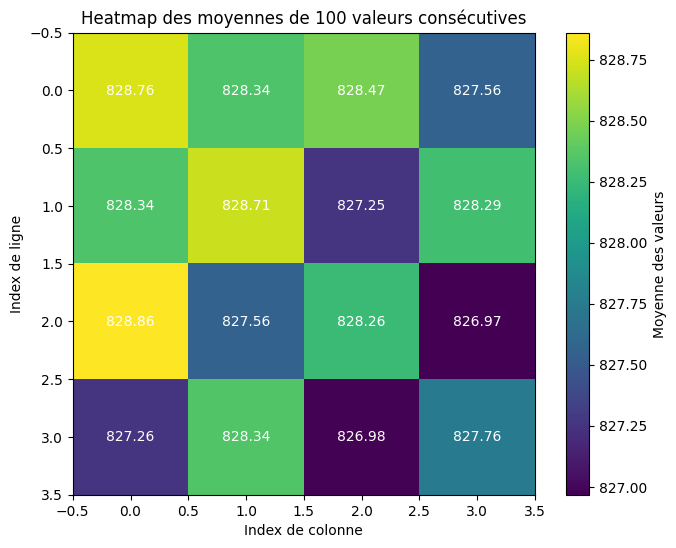

In [170]:
import numpy as np
import matplotlib.pyplot as plt

# Génération de données aléatoires pour l'exemple
data = results
# Calculer les moyennes pour chaque bloc de 100 valeurs
averages = [np.mean(data[i:i+1]) for i in range(0, 1600, 100)]

# Créer une matrice 4x4 à partir de ces moyennes
matrix = np.array(averages).reshape(40, 40)

# Créer un heatmap
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Moyenne des valeurs')
plt.title('Heatmap des moyennes de 100 valeurs consécutives')
plt.xlabel('Index de colonne')
plt.ylabel('Index de ligne')

# Ajouter les annotations pour chaque case
for i in range(4):
    for j in range(4):
        plt.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='white')

plt.show()